# Multihead Attention

<div class="alert alert-block alert-info">

Figure below summarizes what we have accomplished so far. We have focused on the concept and implementation of causal attention in neural networks. Next, we will expand on this concept and implement a multi-head attention module that implements several causal attention mechanisms in parallel.

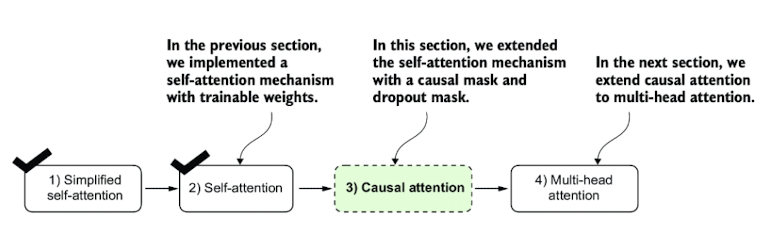

We began with a simplified attention mechanism, added trainable weights, and then added a causal attention mask. Next, we will extend the causal attention mechanism and code multi-head attention, which we will use in our LLM.

</div>

<div class="alert alert-block alert-info">
<h2>What we have learnt so far</h2>

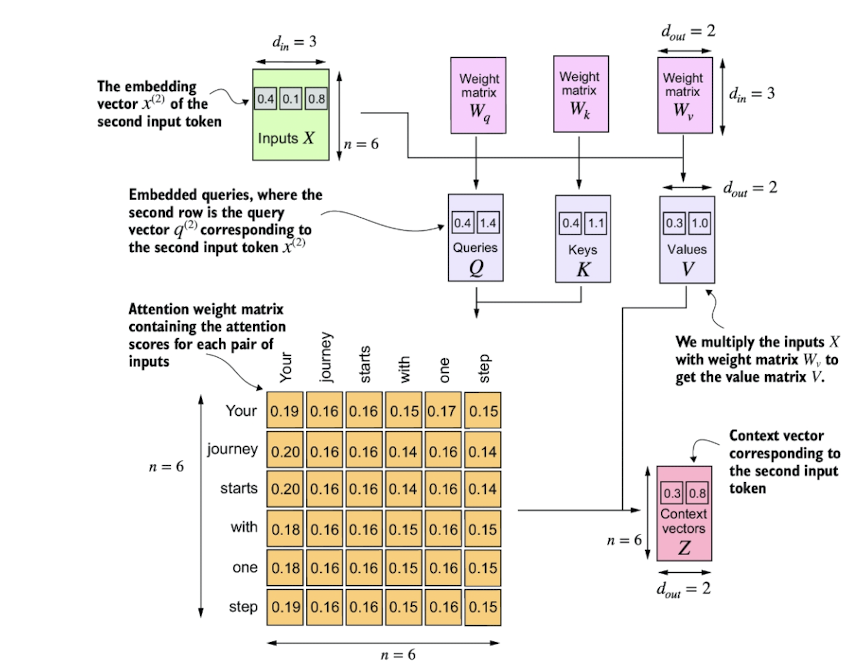

</div>

<div class="alert alert-block alert-info">

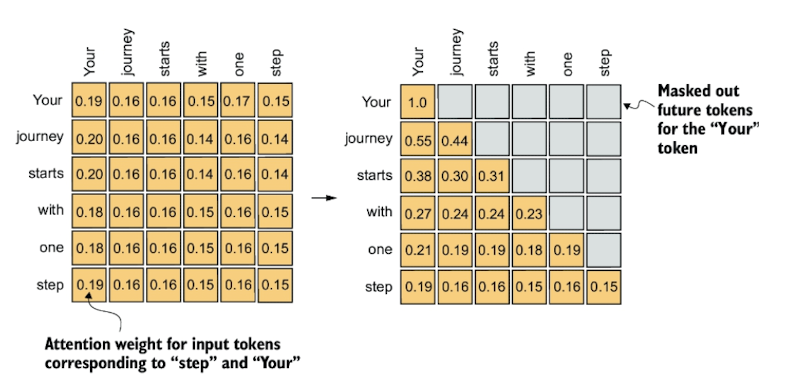

In causal attention, we mask out the attention weights above the diagonal such that for a given input, the LLM can’t access future tokens when computing the context vectors using the attention weights. For example, for the word “journey” in the second row, we only keep the attention weights for the words before (“Your”) and in the current position (“journey”).

The data above diagonal will be masked and it's called as the causal attention mask because we are masking out all of those attention weights that lie above the diagonal.

</div>

<div class="alert alert-block alert-info">
    
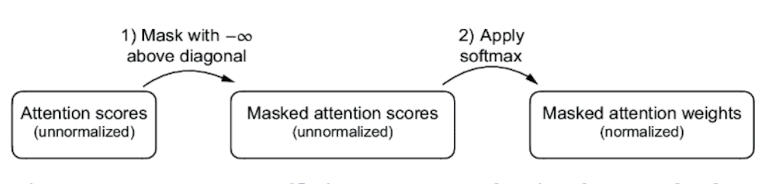

</div>

<div class="alert alert-block alert-info">
<h2>Finally we add dropout</h2>

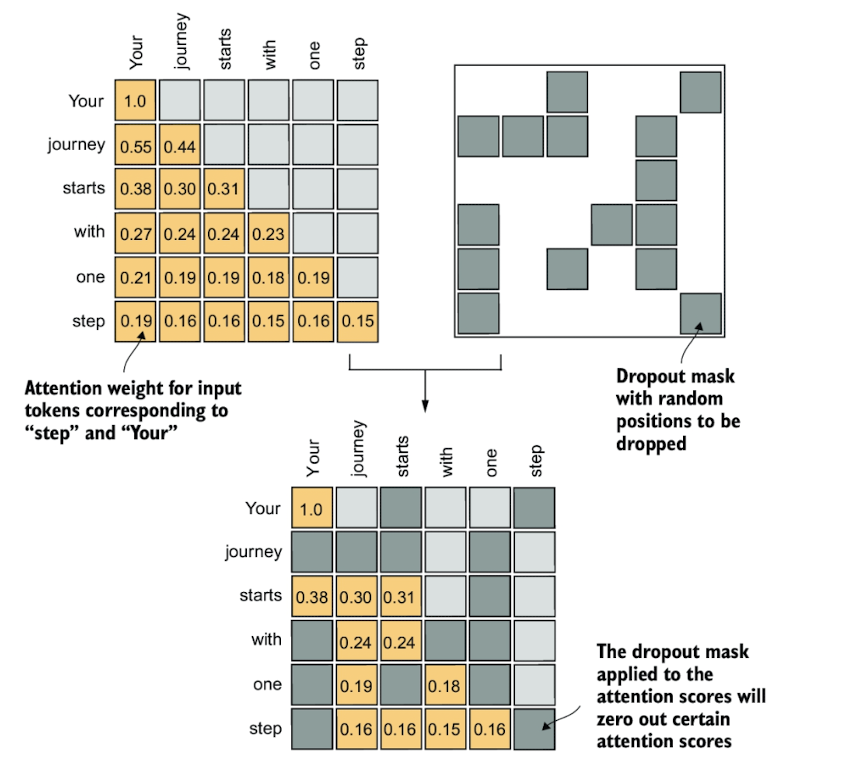

And in our Causal class we added the ability to handle batch as well.

</div>

## EXTENDING SINGLE HEAD ATTENTION TO MULTI-HEAD ATTENTION

<div class="alert alert-block alert-success">
We will extend the previously implemented causal attention class over multiple heads. This is also called multi-head attention. The term “multi-head” refers to dividing the attention mechanism into multiple “heads,” each operating independently. In this context, a single causal attention module can be considered single-head attention, where there is only one set of attention weights processing the input sequentially.

In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism, each with
its own weights, and then combining their outputs

In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism \each with its own weights, and then combining their outputs. Using multiple instances of the self-attention mechanism can be computationally intensive, but it’s crucial for the kind of complex pattern recognition that models like transformer-based LLMs are known for. Figure below illustrates the structure of a multi-head attention module, which consists of multiple single-head attention modules.


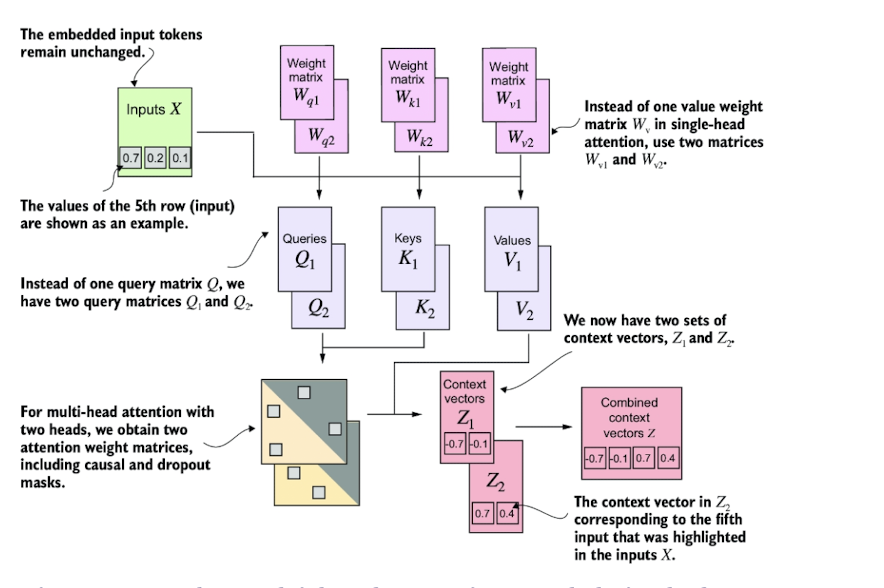

The multi-head attention module includes two single-head attention modules stacked on top of each other. So, instead of using a single matrix Wv for computing the value matrices, in a multi-head attention module with two heads, we now have two value weight matrices: Wv1 and Wv2. The same applies to the other weight matrices, WQ and Wk. We obtain two sets of context vectors Z1 and Z2 that we can combine into a single context vector matrix Z.

    
</div>

<div class="alert alert-block alert-success">
First, we will intuitively build a multi-head attention module by stacking multiple CausalAttention modules.
In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper
class that stacks multiple instances of our previously implemented CausalAttention
module:
    
</div>

In [1]:
import torch.nn as nn

class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

In [7]:

class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)   #concat on columns 


<div class="alert alert-block alert-info">

For example, if we use this MultiHeadAttentionWrapper class with two attention heads (via
num_heads=2) and CausalAttention output dimension d_out=2, this results in a 4-
dimensional context vectors (d_out*num_heads=4)
    
</div>

<div class="alert alert-block alert-success">
To illustrate further with a concrete example, we can use the
MultiHeadAttentionWrapper class similar to the CausalAttention class before:
</div>

In [8]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)  #duplicate inputs for now
print(batch.shape) 

torch.Size([2, 6, 3])


In [9]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens = 6
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


<div class="alert alert-block alert-info">

The first dimension of the resulting context_vecs tensor is 2 since we have two input texts
(the input texts are duplicated, which is why the context vectors are exactly the same for
those). 

The second dimension refers to the 6 tokens in each input. The third dimension
refers to the 4-dimensional embedding of each token.

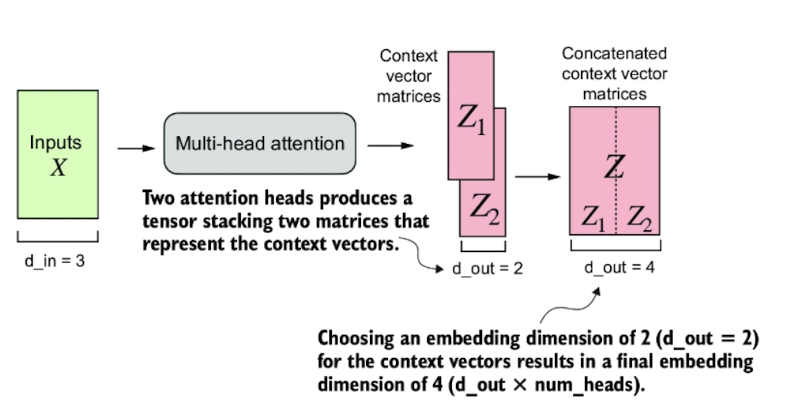

Using the MultiHeadAttentionWrapper, we specified the number of attention heads (num_heads). If we set num_heads=3,  we obtain a tensor with three sets of context vector matrices. In each context vector matrix, the rows represent the context vectors corresponding to the tokens, and the columns correspond to the embedding dimension specified via d_out=6. We concatenate these context vector matrices along the column dimension. If we have three attention heads and an embedding dimension of 2, the final embedding dimension is 3 × 2 = 6.
    
</div>

<h3>3 Attention heads example </h3>

In [13]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)  #duplicate inputs for now
print(batch.shape) 

torch.Size([2, 6, 3])


In [14]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens = 6
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=3)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063,  0.4566,  0.2729],
         [-0.5874,  0.0058,  0.5891,  0.3257,  0.5792,  0.3011],
         [-0.6300, -0.0632,  0.6202,  0.3860,  0.6249,  0.3102],
         [-0.5675, -0.0843,  0.5478,  0.3589,  0.5691,  0.2785],
         [-0.5526, -0.0981,  0.5321,  0.3428,  0.5543,  0.2520],
         [-0.5299, -0.1081,  0.5077,  0.3493,  0.5337,  0.2499]],

        [[-0.4519,  0.2216,  0.4772,  0.1063,  0.4566,  0.2729],
         [-0.5874,  0.0058,  0.5891,  0.3257,  0.5792,  0.3011],
         [-0.6300, -0.0632,  0.6202,  0.3860,  0.6249,  0.3102],
         [-0.5675, -0.0843,  0.5478,  0.3589,  0.5691,  0.2785],
         [-0.5526, -0.0981,  0.5321,  0.3428,  0.5543,  0.2520],
         [-0.5299, -0.1081,  0.5077,  0.3493,  0.5337,  0.2499]]],
       grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 6])


<div class="alert alert-block alert-success">
In this section, we implemented a MultiHeadAttentionWrapper that combined multiple
single-head attention modules. 

However, note that these are processed sequentially via
[head(x) for head in self.heads] in the forward method. 

We can improve this
implementation by processing the heads in parallel. 

One way to achieve this is by
computing the outputs for all attention heads simultaneously via matrix multiplication, as
we will explore in the next section.
</div>

<h2>IMPLEMENTING MULTI-HEAD ATTENTION WITH WEIGHT SPLITS¶</h2>

<div class="alert alert-block alert-info">
In the previous code we had maintained two separate classes.We had maintained a class for the multi-head attention wrapper and we had maintained a class for the causal attention and then we combine both of them into a single multi-head attention class. So here we performed two Matrix multiplications to obtain the two query matrices Q1 and Q2. Simialry we had to do 2 multiplications for getting Key matrices and 2 more to get value matrices. </br>
What we are going to do is the the weight Matrix which we start start out initially itself was a larger weight Matrix and then we multiply the inputs x with the query Matrix to get the queries and then after that we split the queries into two components. 

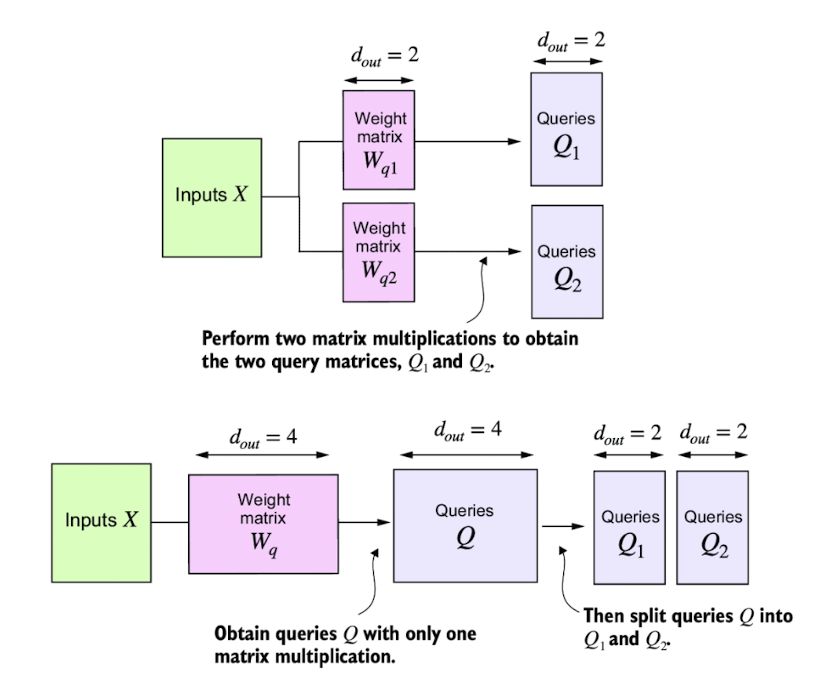

In the MultiHeadAttentionWrapper class with two attention heads, we initialized two weight matrices, Wq1 and Wq2, and computed two query matrices, Q1 and Q2 (top). In the MultiheadAttention class, we initialize one larger weight matrix Wq, only perform one matrix multiplication with the inputs to obtain a query matrix Q, and then split the query matrix into Q1 and Q2 (bottom). We do the same for the keys and values, which are not shown to reduce visual clutter.
 
</div>

<div class="alert alert-block alert-warning">
    
Instead of maintaining two separate classes, MultiHeadAttentionWrapper and
CausalAttention, we can combine both of these concepts into a single
MultiHeadAttention class. 

Also, in addition to just merging the
MultiHeadAttentionWrapper with the CausalAttention code, we will make some other
modifications to implement multi-head attention more efficiently.
</div>

<div class="alert alert-block alert-warning">
    
In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list
of CausalAttention objects (self.heads), each representing a separate attention head.


The CausalAttention class independently performs the attention mechanism, and the
results from each head are concatenated.

In contrast, the following MultiHeadAttention
class integrates the multi-head functionality within a single class. 


It splits the input into
multiple heads by reshaping the projected query, key, and value tensors and then combines
the results from these heads after computing attention.
</div>

<div class="alert alert-block alert-success">

Let's take a look at the MultiHeadAttention class before we discuss it further:
</div>

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-info">

Step 1: Reduce the projection dim to match desired output dim

Step 2: Use a Linear layer to combine head outputs

Step 3: Tensor shape: (b, num_tokens, d_out)

Step 4: We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

Step 6: Compute dot product for each head

Step 7: Mask truncated to the number of tokens

Step 8: Use the mask to fill attention scores

Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

Step 11: Add an optional linear projection
</div>

<div class="alert alert-block alert-warning">

Even though the reshaping (.view) and transposing (.transpose) of tensors inside the
MultiHeadAttention class looks very complicated, mathematically, the
MultiHeadAttention class implements the same concept as the
MultiHeadAttentionWrapper earlier.

</div>

<div class="alert alert-block alert-warning">

On a big-picture level, in the previous MultiHeadAttentionWrapper, we stacked
multiple single-head attention layers that we combined into a multi-head attention layer.


The MultiHeadAttention class takes an integrated approach. 

It starts with a multi-head
layer and then internally splits this layer into individual attention heads

</div>

#### DETAILED EXPLANATION OF THE MULTI-HEAD ATTENTION CLASS

<div class="alert alert-block alert-success">

The splitting of the query, key, and value tensors, is achieved
through tensor reshaping and transposing operations using PyTorch's .view and
.transpose methods. 

The input is first transformed (via linear layers for queries, keys, and
values) and then reshaped to represent multiple heads.

</div>

<div class="alert alert-block alert-success">

The key operation is to split the d_out dimension into num_heads and head_dim, where
head_dim = d_out / num_heads. 

This splitting is then achieved using the .view method: a
tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens,
num_heads, head_dim).
</div>

<div class="alert alert-block alert-success">

The tensors are then transposed to bring the num_heads dimension before the
num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim).

This transposition is crucial for correctly aligning the queries, keys, and values across the
different heads and performing batched matrix multiplications efficiently.
</div>

<div class="alert alert-block alert-success">

To illustrate this batched matrix multiplication, suppose we have the following example
tensor:

</div>

<div class="alert alert-block alert-warning">

Continuing with MultiHeadAttention, after computing the attention weights and context
vectors, the context vectors from all heads are transposed back to the shape (b,
num_tokens, num_heads, head_dim). 

These vectors are then reshaped (flattened) into the
shape (b, num_tokens, d_out), effectively combining the outputs from all heads

</div>

<div class="alert alert-block alert-warning">

Additionally, we added a so-called output projection layer (self.out_proj) to
MultiHeadAttention after combining the heads, which is not present in the
CausalAttention class. 

This output projection layer is not strictly necessary, but it is commonly used in many LLM
architectures, which is why we added it here for completeness.

</div>

<div class="alert alert-block alert-warning">

Even though the MultiHeadAttention class looks more complicated than the
MultiHeadAttentionWrapper due to the additional reshaping and transposition of tensors,
it is more efficient. 

The reason is that we only need one matrix multiplication to compute
the keys, for instance, keys = self.W_key(x) (the same is true for the queries and
values). 
                                              

In the MultiHeadAttentionWrapper, we needed to repeat this matrix multiplication,
which is computationally one of the most expensive steps, for each attention head.

</div>

<div class="alert alert-block alert-success">

The MultiHeadAttention class can be used similar to the SelfAttention and
CausalAttention classes we implemented earlier:
</div>

In [6]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])


<div class="alert alert-block alert-info">

As we can see based on the results, the output dimension is directly controlled by the
d_out argument:

</div>

<div class="alert alert-block alert-warning">

In this section, we implemented the MultiHeadAttention class that we will use in the
upcoming sections when implementing and training the LLM itself. 


Note that while the code is fully functional, we used relatively small embedding sizes and numbers of attention
heads to keep the outputs readable.

</div>

<div class="alert alert-block alert-warning">

For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention
heads and a context vector embedding size of 768. 

The largest GPT-2 model (1.5 billion
parameters) has 25 attention heads and a context vector embedding size of 1600.

Note
that the embedding sizes of the token inputs and context embeddings are the same in GPT
models (d_in = d_out).

</div>